In [1]:
import torch
from WGAN.processing.dataloader import SRDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:1")
device

device(type='cuda', index=1)

In [3]:
train_ds = SRDataset('data/train')
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)

val_ds = SRDataset('data/val')
val_dl = DataLoader(val_ds, batch_size=16, shuffle=True, num_workers=4)

In [4]:
from WGAN.networks.critic import Critic
from WGAN.networks.generator import Generator

critic = Critic().to(device)
generator = Generator().to(device)

# print number of parameters
print(f'Number of parameters in critic:    {sum(p.numel() for p in critic.parameters())}')
print(f'Number of parameters in generator: {sum(p.numel() for p in generator.parameters())}')

Number of parameters in critic:    7964297
Number of parameters in generator: 26930243


In [5]:
# get an sample of the data
for low_res, high_res in train_dl:
    low_res = low_res.to(device)
    high_res = high_res.to(device)
    break

output = critic(high_res)

In [6]:
generator_output = generator(low_res)
generator_output.shape

torch.Size([32, 3, 128, 128])

In [7]:
import WGAN.config.hyperparams as hp
from WGAN.wasserstein_gan import WassersteinGAN

G_optimizer = torch.optim.Adam(generator.parameters(), hp.lr, betas=(0.9, 0.99))
C_optimizer = torch.optim.Adam(critic.parameters(), hp.lr, betas=(0.9, 0.99))

trainer = WassersteinGAN(
        generator,
        critic,
        G_optimizer,
        C_optimizer
    )

In [8]:
trainer.train(train_dl, val_dl)

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 1 has a total capacity of 23.68 GiB of which 5.56 MiB is free. Process 1477298 has 7.02 GiB memory in use. Including non-PyTorch memory, this process has 16.64 GiB memory in use. Of the allocated memory 15.78 GiB is allocated by PyTorch, and 635.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
# load 
checkpoints = '/home/victornasc/Remote-Sensing-Image-Super-Resolution/models/'
# load critic
critic.load_state_dict(torch.load(checkpoints + 'C_100.pth'))
# load generator
generator.load_state_dict(torch.load(checkpoints + 'G_100.pth'))

# # get an sample of the data
# for low_res, high_res in train_dl:
#     low_res = low_res.to(device)
#     high_res = high_res.to(device)
#     break

# output = critic(high_res)


/tmp/ipykernel_1502487/2607415736.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  critic.load_state_dict(torch.load(checkpoints + 'C_100.pth'))
/tmp/ipykernel_1502487/26

<All keys matched successfully>

In [6]:
# get an sample of the data

test_ds = SRDataset('data/test')
test_dl = DataLoader(test_ds, batch_size=8, shuffle=True, num_workers=4)

for low_res, high_res in test_dl:
    low_res = low_res.to(device)
    high_res = high_res.to(device)
    break

In [7]:
generator_output = generator(low_res)
generator_output.shape

torch.Size([8, 3, 512, 512])

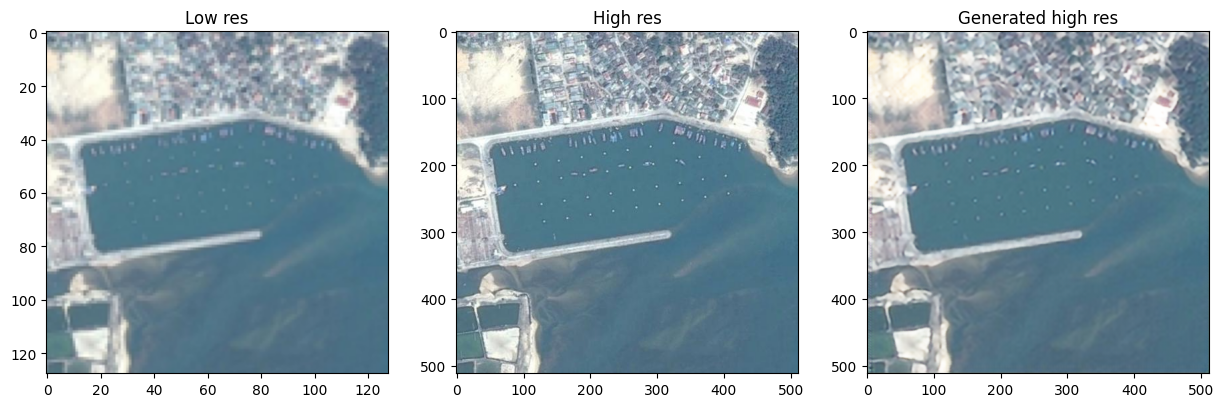

In [8]:
# plot single low high and output
idx = 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(low_res[idx].cpu().detach().numpy().transpose(1, 2, 0))
plt.title('Low res')
plt.subplot(1, 3, 2)
plt.imshow(high_res[idx].cpu().detach().numpy().transpose(1, 2, 0))
plt.title('High res')
plt.subplot(1, 3, 3)
plt.imshow(generator_output[idx].cpu().detach().numpy().transpose(1, 2, 0))
plt.title('Generated high res')
plt.show()

In [11]:
# MAE between high res and generated high res
print(torch.nn.functional.l1_loss(high_res, generator_output).item())

# SSIM
from pytorch_msssim import ssim
print(ssim(high_res, generator_output).item())


0.03013593517243862
0.9999411106109619


In [ ]:
output = critic(high_res)
output